Google colabのたまに以下をインストール

In [ ]:
rm -rf data

In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning
!pip install ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 6.0 MB/s 
     |████████████████████████████████| 18.0 MB 44.0 MB/s 
     |████████████████████████████████| 240 kB 92.7 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 
     |████████████████████████████████| 112 kB 73.7 MB/s 
     |████████████████████████████████| 1.6 MB 61.5 MB/s 
     |████████████████████████████████| 49 kB 7.7 MB/s 
     |████████████████████████████████| 37.5 MB 50 kB/s 
     |████████████████████████████████| 49 kB 7.7 MB/s 
     |████████████████████████████████| 943 kB 64.4 MB/s 
     |████████████████████████████████| 4.1 MB 56.4 MB/s 
     |████████████████████████████████| 112 kB 64.0 MB/s 
  Created wheel for qiskit: filename=qiskit-0.37.2-py3-none-any.whl size=12109 sha256=5888e9e964e58325d821dee2ca5a569468a238c0b32a3dea6cd3ac55f77f9651
  Stored in directory: /root/.cache/pip/wheels/e6/bd/f3/26c31

import とversion確認


In [ ]:
import qiskit
from qiskit import  *
qiskit.__version__

'0.21.2'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

In [ ]:
# declare quantum instance
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

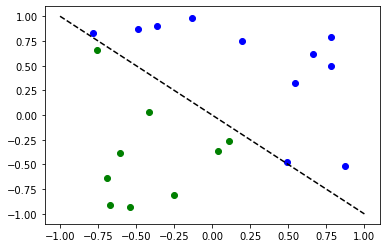

In [ ]:
# Generate random dataset

# Select dataset dimension (num_inputs) and size (num_samples)
num_inputs = 2
num_samples = 20

# Generate random input coordinates (X) and binary labels (y)
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}, y01 will be used for CircuitQNN example
y = 2 * y01 - 1  # in {-1, +1}, y will be used for OplowQNN example

# Convert to torch Tensors
X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

# Plot dataset
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [ ]:
# Set up QNN
# Note: we are not providing them explicitly in this examples,
# but TwoLayerQNN requires a feature_map and ansatz to work.
# By default, these parameters are set to  ZZFeatureMap
# and RealAmplitudes (respectively).
qnn1 = TwoLayerQNN(num_qubits=num_inputs, quantum_instance=qi)
print(qnn1.operator)

# Set up PyTorch module
# Note: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐»
  q_0: ┤0                         ├»
       │  ZZFeatureMap(x[0],x[1]) │»
  q_1: ┤1                         ├»
       └──────────────────────────┘»
  «     ┌──────────────────────────────────────────────────────────┐
  «q_0: ┤0                                                         ├
  «     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
  «q_1: ┤1                                                         ├
  «     └──────────────────────────────────────────────────────────┘
  )
])
Initial weights:  [-0.0756335   0.00126599  0.03885249  0.01622332 -0.06004487  0.06082491
  0.04308143  0.0477968 ]


In [ ]:
# Test with a single input
model1(X_[0, :])

tensor([-0.0916], grad_fn=<_TorchNNFunctionBackward>)

In [ ]:
# Define optimizer and loss
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model1.train()  # set model to training mode


# Note from (https://pytorch.org/docs/stable/optim.html):
# Some optimization algorithms such as LBFGS need to
# reevaluate the function multiple times, so you have to
# pass in a closure that allows them to recompute your model.
# The closure should clear the gradients, compute the loss,
# and return it.
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model1(X_), y_)  # Evaluate loss function
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer step4
optimizer.step(closure)

17.323471069335938
14.596670150756836
14.31265926361084
14.170870780944824
13.602341651916504
13.542295455932617
12.925769805908203
12.971969604492188
12.811230659484863
12.807812690734863
12.806640625
12.805679321289062
12.805428504943848
12.805415153503418
12.805413246154785
12.805413246154785


tensor(17.3235, grad_fn=<MseLossBackward0>)

Accuracy: 0.85


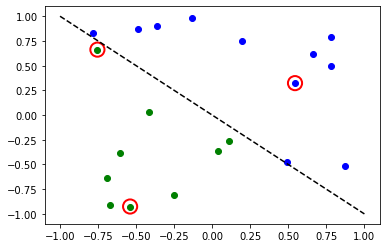

In [ ]:
# Evaluate model and compute accuracy
y_predict = []
for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print("Accuracy:", sum(y_predict == y) / len(y))

# Plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [ ]:
# Define feature map and ansatz
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, entanglement="linear", reps=1)

# Define quantum circuit of num_qubits = input dim
# Append feature map and ansatz
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))


# Define CircuitQNN and initial setup
parity = lambda x: "{:b}".format(x).count("1") % 2  # optional interpret function
output_shape = 2  # parity = 0, 1
qnn2 = CircuitQNN(
    qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    quantum_instance=qi,
)

# Set up PyTorch module
# Reminder: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn2.num_weights) - 1)
print("Initial weights: ", initial_weights)
model2 = TorchConnector(qnn2, initial_weights)

Initial weights:  [-0.07378845 -0.07524924  0.08551251 -0.02048436]


In [ ]:
# Define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()  # Our output will be in the [0,1] range

# Start training
model2.train()

# Define LBFGS closure method (explained in previous section)
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model2(X_), y01_)  # Calculate loss
    loss.backward()  # Backward pass

    print(loss.item())  # Print loss
    return loss


# Run optimizer (LBFGS requires closure)
optimizer.step(closure);

0.7782841920852661
0.7725659608840942
0.7659587264060974
0.7584818005561829
0.7502431869506836
0.7414529919624329
0.7324103713035583
0.8014973402023315
0.8160041570663452
0.7365812063217163
0.8133867383003235
0.7366460561752319
0.641613245010376
0.6588781476020813
0.7351698875427246
0.7705353498458862
0.7696670293807983
0.7617349028587341
0.7817143797874451
0.659096360206604


Accuracy: 0.4


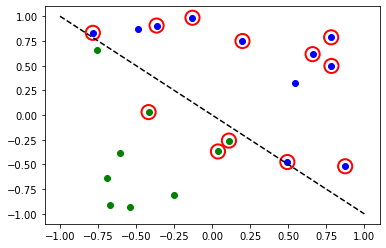

In [ ]:
# Evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print("Accuracy:", sum(y_predict == y01) / len(y01))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

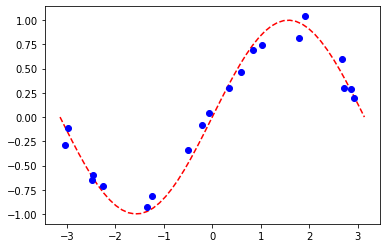

In [ ]:
# Generate random dataset

num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X) + eps * (2 * algorithm_globals.random.random([num_samples, 1]) - 1)
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")
plt.plot(X, y, "bo")
plt.show()

In [ ]:
# Construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# Construct simple feature map
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# Construct QNN
qnn3 = TwoLayerQNN(1, feature_map, ansatz, quantum_instance=qi)
print(qnn3.operator)

# Set up PyTorch module
# Reminder: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn3.num_weights) - 1)
model3 = TorchConnector(qnn3, initial_weights)

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
     ┌───────┐┌───────┐
  q: ┤ fm(x) ├┤ vf(y) ├
     └───────┘└───────┘
  )
])


In [ ]:
# Define optimizer and loss function
optimizer = LBFGS(model3.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model3.train()  # set model to training mode

# Define objective function
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model3(Tensor(X)), Tensor(y))  # Compute batch loss
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer
optimizer.step(closure)


16.66506004333496
2.710993528366089
27.2949275970459
13.107039451599121
19.85063362121582
3.93727445602417
3.811336040496826
0.20423352718353271
0.1954575926065445
0.19540949165821075


tensor(16.6651, grad_fn=<MseLossBackward0>)

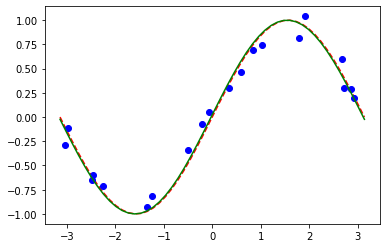

In [ ]:
# Plot target function
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")

# Plot data
plt.plot(X, y, "bo")

# Plot fitted line
y_ = []
for x in np.linspace(lb, ub):
    output = model3(Tensor([x]))
    y_ += [output.detach().numpy()[0]]
plt.plot(np.linspace(lb, ub), y_, "g-")
plt.show()

#パート 2: MNIST 分類、ハイブリッドQNN

2番目の部分では、TorchConnector を使用したハイブリッドの量子古典的なニューラルネットワークの活用方法を示します。 より複雑な画像分類タスクをMNISTの手書きの数字データセットで実行します。

ハイブリッドの量子古典ニューラルネットワークの詳細(TorchConnector の前)については、Qiskit Textbook の対応するセクションを参照してください。

In [ ]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

##ステップ 1: 学習とテスト用のデータ・ローダーの定義¶

torchvision API を利用して、 MNIST データセット のサブセットを直接ロードし、学習とテストのための DataLoader (リンク) を定義します。

In [ ]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



簡単な可視化を実行すると、学習のデータセットは手書きの0と1の画像で構成されていることがわかります。

#データセット変更


In [ ]:
ls

data.zip  sample_data/


In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/0/
   creating: data/1/
  inflating: data/0/img019.png       
  inflating: __MACOSX/data/0/._img019.png  
  inflating: data/0/img018.png       
  inflating: __MACOSX/data/0/._img018.png  
  inflating: data/0/img020.png       
  inflating: __MACOSX/data/0/._img020.png  
  inflating: data/0/img008.png       
  inflating: __MACOSX/data/0/._img008.png  
  inflating: data/0/img009.png       
  inflating: __MACOSX/data/0/._img009.png  
  inflating: data/0/img013.png       
  inflating: __MACOSX/data/0/._img013.png  
  inflating: data/0/img007.png       
  inflating: __MACOSX/data/0/._img007.png  
  inflating: data/0/img006.png       
  inflating: __MACOSX/data/0/._img006.png  
  inflating: data/0/img012.png       
  inflating: __MACOSX/data/0/._img012.png  
  inflating: data/0/img004.png       
  inflating: __MACOSX/data/0/._img004.png  
  inflating: data/0/i

In [ ]:
import torch
from torch.utils.data import Dataset

import os
import random
from PIL import Image

import numpy as np

import torchvision

In [ ]:
class MyDatasets(Dataset):
    def __init__(self, directory = None, transform = None):
        
        self.directory = directory
        self.transform = transform
        self.label, self.label_to_index = self.findClasses()
        self.img_path_and_label = self.createImgPathAndLabel()

    def __len__(self):
        return len(self.img_path_and_label)

    def __getitem__(self, index):
        img_path, label = self.img_path_and_label[index]
        
        img = Image.open(img_path)

        img = img.resize((28,28)) # リサイズ

        if self.transform:
            img = self.transform(img)

        #print(np.shape(img))
        #print(np.array(img).astype(np.float32))

        #img = img.resize((96,96)) # リサイズ
        #img = np.array(img).astype(np.float32).transpose(1, 0) # Dataloader で使うために転置する
        #img = np.array(img).astype(np.float32)
        #print(img)
        #img = np.array(img).astype(np.float32).transpose(1,2, 0, 1) # Dataloader で使うために転置する
        #print(img)
        #print(label)
        
        #return img, label
        #tensor化
        #trans1 = torchvision.transforms.ToTensor()
        #label = trans1(label)

        #return img, label
        return img, torch.tensor(np.array([int(label)]))

    def findClasses(self):
        classes = [d.name for d in os.scandir(self.directory)]
        #classes.remove('.ipynb_checkpoints')
        classes.remove('.DS_Store')
        classes.sort()
        class_to_index = {class_name: i for i, class_name in enumerate(classes)} # {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
        #print(classes, class_to_index)
        return classes, class_to_index

    def createImgPathAndLabel(self):
        if self.directory:
            img_path_and_labels = []
            directory = os.path.expanduser(self.directory)
            for target_label in sorted(self.label_to_index):
                label_index = self.label_to_index[target_label]
                target_dir = os.path.join(directory, target_label)

                for root, _, file_names in sorted(os.walk(target_dir, followlinks = True)):
                    for file_name in file_names:
                        img_path = os.path.join(root, file_name)
                        img_path_and_label = img_path, target_label
                        img_path_and_labels.append(img_path_and_label)
            
            random.shuffle(img_path_and_labels)

        return img_path_and_labels

In [ ]:
directory = './data' #r'data'
trans = torchvision.transforms.Compose([torchvision.transforms.Grayscale(), torchvision.transforms.ToTensor()])
datasets = MyDatasets(directory, trans)
print(datasets)
print(len(datasets))
#print(datasets[2][0])

40


TypeError: ignored

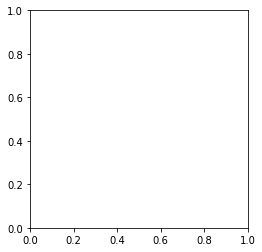

In [ ]:
import matplotlib.pyplot as plt
#print(datasets.size())
img = datasets[0][0]
plt.imshow(img)
plt.show()

(48, 48)
0 40


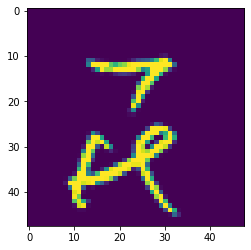

In [ ]:
import matplotlib.pyplot as pltz

image, label = datasets[0]
print(image.shape)
print(label,  len(datasets))

#plt.imshow(image.transpose(2, 1, 0).astype(np.uint8))
plt.imshow(image.transpose(1, 0).astype(np.uint8))

In [ ]:
print(int(len(datasets)))

n_samples = len(datasets) # n_samples is 60000
train_size = int(len(datasets) * 0.8) # train_size is 48000
val_size = n_samples - train_size # val_size is 48000

train_dataset, valid_dataset = torch.utils.data.random_split(
    datasets, 
    [train_size, val_size]
)

print(train_dataset)
print(valid_dataset)

40


In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
# 学習用Dataloader
#train_dataloader = DataLoader(
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=2, 
    drop_last=True,
    pin_memory=True
)

# 評価用Dataloader
#valid_dataloader = DataLoader(
valid_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=2, 
    drop_last=True,
    pin_memory=True
)

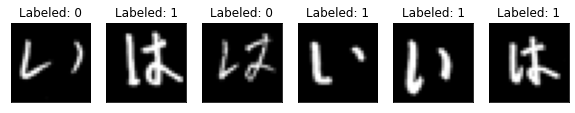

In [ ]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    #axes[n_samples_show - 1].imshow(images[0, 0], cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))
    #axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0]))

    n_samples_show -= 1

In [ ]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
#test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

##ステップ 2: QNNとハイブリッド・モデルの定義¶

この2番目のステップは、 TorchConnector の実力を示します。 量子ニューラルネットワーク層を定義した後 (この場合は TwoLayerQNN) 、torchコネクターを TorchConnector(qnn) として初期化することで、torch Module のレイヤーに埋め込むことができます。

⚠️ 注意: ハイブリッド・モデルで、適切な勾配バックプロパゲーションを行うためには、QNNの初期化中に、初期パラメーター input_gradients を TRUE に設定する必要があります。

In [ ]:
# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = TwoLayerQNN(
        2,
        feature_map,
        ansatz,
        input_gradients=True,
        exp_val=AerPauliExpectation(),
        quantum_instance=qi,
    )
    return qnn


qnn4 = create_qnn()
print(qnn4.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])


In [ ]:
# Define torch NN module


class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model4 = Net(qnn4)

##ステップ 3: 学習

In [ ]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        #print(target[0])
        loss = loss_func(output, target[0])  # Calculate loss
        #loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
Training [10%]	Loss: -0.4485
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
Training [20%]	Loss: -0.5549
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([0])
tensor

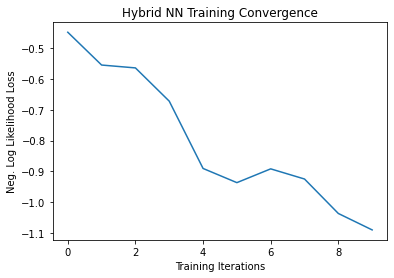

In [ ]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

次に、トレーニング済みモデルを保存して、ハイブリッドモデルを保存し、後で推論に再利用する方法を示します。ハイブリッドモデルを保存およびロードにおいて、TorchConnector を使用する場合、モデルの保存およびロードに関する PyTorch の推奨事項に従ってください。

In [ ]:
torch.save(model4.state_dict(), "model4.pt")

##ステップ 4: 評価¶

モデルを再作成し、以前に保存したファイルから状態をロードすることから始めます。別のシミュレーターまたは実際のハードウェアを使用してQNNレイヤーを作成します。したがって、クラウドで利用可能な実際のハードウェアでモデルをトレーニングしてから、推論にシミュレーターまたはその逆を使用できます。簡単にするために、上記と同じ方法で新しい量子ニューラルネットワークを作成します。

In [ ]:
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("model4.pt"))

<All keys matched successfully>

In [ ]:
batch_size = 1

model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    #for batch_idx, (data, target) in enumerate(test_loader):  
    for batch_idx, (data, target) in enumerate(valid_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        #loss = loss_func(output, target)
        loss = loss_func(output, target[0])
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(valid_loader) / batch_size * 100
        )
    )

Performance on test data:
	Loss: -1.2142
	Accuracy: 100.0%


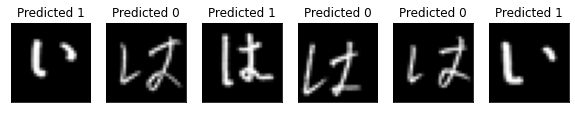

In [ ]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model5.eval()
with no_grad():
    #for batch_idx, (data, target) in enumerate(test_loader):
    for batch_idx, (data, target) in enumerate(valid_loader):
        if count == n_samples_show:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

これで、Qiskit 機械学習を使用して、独自のハイブリッド・データセットとアーキテクチャを試すことができます。 頑張ってください!

In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright